<!--HEADER-->
*[Guia de aulas da disciplina de Modelagem Matemática](https://github.com/rmsrosa/modelagem_matematica) do [IM-UFRJ](https://www.im.ufrj.br).*

<!--NAVIGATOR-->

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/11.00-Aula11.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
&nbsp;
<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/11.00-Aula11.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>
&nbsp;
<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/11.00-Aula11.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;

[<- Aula 9: Pêndulo via deteção de movimento](09.00-Aula9.ipynb) | [Página Inicial](00-Sumario.ipynb) 

---


# Aula 10: Epidemiologia, tipos de modelos, o modelo clássico SIR e o modelo SIR individual

## Objetivos

- Diferentes níveis de modelagem de epidemiologia
- O modelo clássico SIR (Suscetíveis, Infectados e Recuperados) em nível global
- O modelo SIR em nível individual
- Método de Monte-Carlo para a simulação numérica do modelo SIR em nível individual
- Outros tipos de epidemia e de modelos 

- Referências:
    - [M. J. Keeling,  K. T. D. Eames,  Networks and epidemic models, J. R. Soc. Interface (2005) 2, 295–307 doi:10.1098/rsif.2005.0051](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2005.0051)

## Importando bibliotecas e definindo funções a serem usadas abaixo

In [1]:
from os import path

import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from scipy.integrate import odeint

import networkx as nx

import matplotlib.pyplot as plt

import io, base64
from IPython.display import Image, HTML

## Modelos matemáticos de epidemiologia

Classificação por nível de detalhamento e tipo de interação:

- **compartimental** ou **por compartimento** *(compartment models):* a população é dividida em grandes compartimentos referentes a diferentes estágios da epidemia (suscetíveis, infectados, etc.) e a dinâmica é feita entre os compartimentos, sem detalhamento dos indivíduos que formam cada compartimento.

- **individual** *(individual- or agent-based models):* A população é tratada individualmente, com a interação dada de maneira aleatória entre os indivíduos, segundo determinadas distribuições de probabilidades.

- **em rede** *(network models):* A população é tratada individualmente, ou em determinados grupos com características comuns, que compões diferentes vértices em redes e interagem segundo arestas entre determinados vértices.

## Modelo SIR compartimental

Este é o exemplo clássico de **modelo compartimental**.

Neste modelo, a população é definida em três "compartimentos":

- **suscetíveis**

- **infectados**

- **recuperados**

### Dinâmica do modelo

Neste modelo, a dinâmica é definida da seguinte forma:

- A cada encontro entre um indivíduo suscetível e um infectado, há uma probabilidade do indivíduo suscetível se tornar infectado, com essa probabilidade dada por um **fator de transmissão**

- O número de encontros entre indivíduos suscetíveis e infectados é uma fração do número de indivíduos suscetíveis, com essa fração dada pela proporção de indivíduos suscetíveis na população total.

- Os indivíduos infectados tendem a se tornam recuperados depois de um determinado **tempo de recuperação** típico da doença.

### Representação do modelo na forma de grafo

In [2]:
dg = nx.DiGraph()
dg.add_node(1, compartimento='suscetíveis', node_color='mediumaquamarine')
dg.add_node(2, compartimento='infectados', node_color='tomato')
dg.add_node(3, compartimento='recuperados', node_color='skyblue')
#dg.add_node(4, compartimento='falecidos')
dg.add_edges_from([(j,j+1) for j in iter(list(dg.nodes())[:-1])])

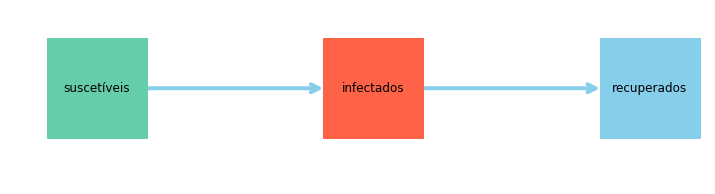

In [3]:
plt.figure(figsize=(12,3))

pos = {j: (j,0) for j in iter(dg.nodes)}
labels = {j: dg.node[j]['compartimento'] for j in iter(dg.nodes)}    
color_map = [dg.node[j]['node_color'] for j in iter(dg.nodes)]

nx.draw_networkx_nodes(dg, pos, node_size=10000, with_labels=True, node_shape='s', node_color=color_map)
nx.draw_networkx_labels(dg, pos, labels=labels, fontsize=24)
nx.draw_networkx_edges(dg, pos, node_size=10000, arrowstyle='->', arrowsize=20, 
                       edge_color='skyblue', width=4)
plt.axis('off')
plt.show()

### Representação do modelo na forma de ação de massas

$$
\begin{cases}
  S + I \rightarrow 2I, & \text{(processo de infeção)} \\
  I \rightarrow R, & \text{(processo de reação)}.
\end{cases}
$$

## Equações diferenciais do modelo SIR

O próximo passo é implementar o sistema de equações diferenciais para cada compartimento SIR.

### Os compartimentos

Definimos

- $S =$ número de indivíduos **suscetíveis**;

- $I =$ número de indivíduos **infectados**;

- $R =$ número de indivíduos **recuperados**;

A **população**, formada pelo **número total de indivíduos**, é dada por

$$ N = S + I + R
$$

### Sistema em termos do número total de indivíduos em cada compartimento

Temos 

$$ 
  \begin{cases}
    S' = \displaystyle - \beta\frac{I}{N} S, \\
    I' = \displaystyle \beta\frac{I}{N} S - \gamma I, \\
    R' = \gamma I
  \end{cases}
$$

Os parâmetros (positivos) $\beta$, e $\gamma$ têm a seguinte interpretação:

- $\beta:$ **fator_de_transmissao**

- $\gamma:$ **fator_de_recuperacao**

### Conservação da população

O modelo SIR acima não inclui natalidade e mortalidade. Nesse caso, a população total é conservada. Podemos conferir que o modelo tem essa propriedade verificando que

$$ \frac{\rm{d}}{\rm{dt}} (S + I + R) = 0.
$$

Observe, ainda, que as equações para $S$ e $I$ estão desacopladas de $R$. Assim, para a evolução da epidemia, podemos considerar apenas o sistema em $S$ e $I$ e deduzir $R$ a partir de $S$, $I$ e $N$, ou seja, evoluimos de acordo com

$$ \begin{cases}
     S' = \displaystyle - \beta\frac{I}{N} S, \\
    I' = \displaystyle \beta\frac{I}{N} I - \gamma I, \\
   \end{cases}
$$

e encontramos $R$ através de

$$ R = N - S - I.
$$

### Representação em termos da densidade de indivíduos

Podemos, também, considerar as densidades de indivíduos (em relação à popuação total) em cada comportamento:

- $s = S/N$ densidade de indivíduos **suscetíveis**;

- $i = I/N$ densidade de indivíduos **infectados**;

- $r = R/N$ densidade de indivíduos **imunes**.

Nesse caso,

$$ s + i + r = 1
$$

### Sistema em termos da densidade de indivíduos

Basta dividir as equações diferenciais para $S$, $I$ e $R$ por $N$ e substituir as variáveis para obtermos

$$ 
  \begin{cases}
    s' = - \beta si, \\
    i' = \beta si - \gamma i, \\
    r' = \gamma i\\
  \end{cases}
$$

### Análise do sistema e condições para epidemia

Uma situação de **epidemia** é caracterizada pelo **aumento de infectados em um determinado intervalo de tempo**.

Olhando o sistema, vemos que 

$$ s' = -\beta s i \leq 0,
$$ 
de modo que $s$ é decrescente, com $s(t) \leq s(0)$, para $t\geq 0$. Em termos da população de individuos suscetíveis, com $S(0)=S_0$, temos

$$ S(t) \leq S_0.
$$

Por sua vez, a proporção de infectados satisfaz 

$$ i' = (\beta s - \gamma)i,
$$ 
de modo que, assumindo  $i$ positivo, temos que $i$ é crescente quando $s > \gamma/\beta$ e é decrescente quando $s < \gamma/\beta$. Em termos da população de suscetíveis, temos que

$$ \textbf{Situação de Epidemia} \quad \Longleftrightarrow \quad S_0 > \frac{\gamma N}{\beta}
$$

### Integral do sistema e plano de fases

Podemos facilmente achar uma integral do sistema e traçar o seu plano de fases.

Dividindo $i'$ por $s'$, temos

$$ \frac{\rm{d} i}{\rm{d} s} = \frac{\beta s - \gamma}{-\beta s} = \frac{\gamma}{\beta s} -1.
$$

que pode ser integrada diretamente. Resolvendo, obtemos

$$ i + s - \frac{\gamma}{\beta}\ln|s| = C
$$ 

### Implementação da resolução do sistema de equações diferenciais

#### Parâmetros e dados iniciais

In [4]:
# população total
N = 100

# população inicial em cada estágio
S0 = 90 # suscetíveis
I0 = 10 # infectados
R0 = N - S0 - I0 # recuperados

# populacao inicial para o sistema reduzido
X0 = [S0, I0]

# parâmetros
beta = 0.4 # fator de transmissão
gamma = 0.15 # fator de recuperação

#### Função taxa de evolução

In [5]:
def taxa_de_evolucao(X, t, N, beta, gamma):
    S, I = X
    dXdt = [- beta*I*S/N, beta*I*S/N - gamma*I]
    return dXdt

#### Resolvendo o sistema

In [6]:
t = np.linspace(0, 100, 101)
sol = odeint(taxa_de_evolucao, X0, t, args=(N, beta, gamma))
S = sol[:,0]
I = sol[:,1]
R = N*np.ones_like(S) - S - I

#### Gráfico da evolução de cada compartimento

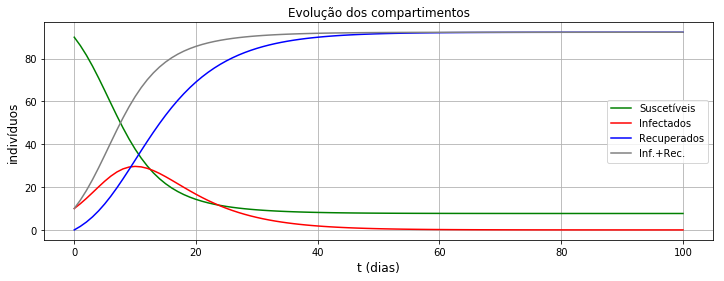

In [7]:
plt.figure(figsize=(12,4))
plt.plot(t, S, 'g', label='Suscetíveis')
plt.plot(t, I, 'r', label='Infectados')
plt.plot(t, R, 'b', label='Recuperados')
plt.plot(t, I + R, 'gray', label='Inf.+Rec.')
plt.legend(loc='best')
plt.xlabel('t (dias)', fontsize=12)
plt.ylabel('indivíduos', fontsize=12)
plt.title('Evolução dos compartimentos')
plt.grid()
plt.show()

#### Verificando condição de epidemia

Para termos uma situação de epidemia, devemos ter $S_0> \gamma N/\beta$, ou seja

$$ \frac{S_0 \beta}{\gamma N} > 1
$$

No exemplo, temos

In [8]:
S0*beta/gamma/N

2.4

## Modelo SIR individual com encontros uniformemente aleatórios

Aqui, descrevemos o fundamento do modelo SIR baseado em uma modelagem indivídual, com interações e transmissões definidas por probabilidades uniformes.

### Representação da população

Neste modelo, a população é determinada por uma lista, onde cada elemento da lista representa um indivíduo. Cada indivíduo é classificado entre **suscetível**, **infectado**, e **recuperado**. Cada classificação corresponde a um número, a saber, 1, 2 e 3.

### Dinâmica do modelo

A cada "dia", toda a população interage em pares. Se um **infectado** interagir com um **suscetível** e se um número escolhido aleatoriamente, de maneira uniforme, entre 0 e 1, estiver acima de uma determinada **taxa de transmissão**, o indivíduo **suscetível** se torna **infectado**. Nada acontece nas outras interações.

Além disso, a cada "dia", cada indivíduo **infectado** pode se tornar **recuperado**, se, novamente, um número escolhido aleatoriamente, de maneira uniforme, entre 0 e 1, estiver acima de uma **taxa de recuperação**.

#### Parâmetros

São definidos os seguintes parâmetros para o problema:

- $N$=`num_individuos`, definindo o número total de indivíduos.

- $\beta$=`fator_de_transmissao`, como sendo um número entre 0 e 1 definindo a probabilidade da transmissao da doenca ocorrer quando do encontro de um indivíduo suscetível com um infectado.

- $\gamma$=`fator_de_recuperacao`, como sendo um número entre 0 e 1 definindo a probabilididade, a cada unidade de tempo, de um indivíduo infectado se recuperar e se tornar imune. É inversamente proporcional ao tempo de recuperação, em múltiplos da unidade de tempo.


#### Condição inicial

Precisamos definir o estágio inicial da população.

Vamos assumir que, inicialmente, não há recuperados, apenas suscetíveis e infectados. Assim, só precisamos definir o seguinte parâmetro para a condição inicial:

- `num_infectados0`, definindo o número inicial de indivíduos infectados

O restante é de suscetíveis.

Quais serão os indivíduos infectados será determinado aleatoriamente, de maneira uniforme entre a população.

In [9]:
num_individuos = 100
num_infectados0 = 10
fator_de_transmissao = 0.8
fator_de_recuperacao = 0.15

#### Inicialização dos parâmetros da população

Com base nos parâmetros acima, definimos a situação de cada indivíduo da população inicial `populacao0`, como sendo todos *suscetíveis*, exceto um amostra aleatório de indivíduos *infectados*.

In [10]:
populacao0 = 2*np.ones(num_individuos)
infectados0 = np.random.choice(num_individuos, num_infectados0)
populacao0[infectados0] = np.ones(num_infectados0)
print(populacao0)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 1. 2. 2. 1. 1. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2.
 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 2.]


#### Função de interação entre indivíduos

Os passos da função de interação:

1. Recebe o estado de dois indivíduos (se `1`, `2` ou `3`), junto com o parâmetro `fator_de_transmissao`;

1. No caso em que um dos indivíduos é suscetível e o outro é infectado, o que ocorre apenas se um for igual a `1` e o outro, igual a `2`, ou seja, apenas se o produto desses números for igual a `2`, e ainda, se um número gerado aleatoriamente (com probabilidade uniforme entre 0 e 1) for menor do que o `fator_de_transmissao`:

    1. O indivíduo suscetível se torna infectado e o outro se mantém infectado, retornando o valor `2` para estado de cada indivíduo.

1. Caso negativo em pelo menos um dos testes, retorna os valores originais dos estados dos indivíduos.

In [11]:
@np.vectorize
def interacao(a, b, fator_de_transmissao):
    if a*b == 2 and np.random.rand() < fator_de_transmissao:
        a = 1
        b = 1
    return a, b

#### Função de recuperação dos indivíduos infectados

Para o processo de recuperação de um indivíduo infectado, temos a função abaixo, que funciona da seguinte forma:

1. Recebe o estado do indivíduo (se `1`, `2` ou `3`) e o parâmetro `fator_de_recuperacao`.

1. Se o indivíduo estiver infectado:
    
    1. Gera um número `p` de ponto flutuante aleatório entre 0 e 1, a partir de uma distribuição uniforme.

    1. Se `p` for menor do que o `fator_de_recuperacao`, o indivíduo se torna *imune* e a função retorna o estado `3`.

1. Se o indivíduo não estiver infectado, a função retorna o estado original

In [12]:
@np.vectorize
def recuperacao(a, fator_de_recuperacao):
    if a == 1:
        p = np.random.rand()
        if p < fator_de_recuperacao:
            return 3
        else:
            return 1
    else:
        return a

#### Evolução diária

Esta função recebe a variável `populacao` com a lista do estado de cada indivíduo (em um certo instante de tempo), e faz o seguinte:

1. Seleciona aleatoriamente os pares de indivíduos para interagirem.

1. Aplica a função de `interacao` aos pares selecionado.

1. Aplica a função de `recuperacao` a todos os indivíduos.

1. Retorna o novo estado da `populacao`.

#### Código vetorizado para a evolução diária

Para acelerar, usamos a forma vetorizada das funções de interação e recuperação e podemos definir o código para a evolução diária invocando essas funções diretamente com o *array* da população.

In [13]:
def evolui(populacao, fator_de_transmissao, fator_de_recuperacao):
    ind = np.random.choice(len(populacao), [len(populacao)//2,2])
    populacao = recuperacao(populacao, fator_de_recuperacao)
    populacao[ind[:,0]], populacao[ind[:,1]] = interacao(populacao[ind[:,0]], populacao[ind[:,1]], 
                                                         fator_de_transmissao)

    return populacao

#### Evolução

1. Define o número de "dias" `tmax` até onde evoluir o processo.

1. Copia a população inicial `populacao0` para uma nova variável `populacao` com o estado diário de cada indivíduo da população.

1. Inicializa os vetores para contar e armazenar na memória, a cada dia, o número de infectados, suscetíveis e recuperados.

1. Faz o *loop* de evolução diária, até o número final de dias.

In [14]:
tmax = 100
populacao = np.copy(populacao0)
num_infectados = np.array([num_infectados0])
num_suscetiveis = np.array([num_individuos - num_infectados0])
num_recuperados = np.array([0])
for t in range(1,tmax):
    populacao = evolui(np.copy(populacao), fator_de_transmissao, fator_de_recuperacao)
    num_infectados = np.hstack([num_infectados, np.count_nonzero(populacao==1)])
    num_suscetiveis = np.hstack([num_suscetiveis, np.count_nonzero(populacao==2)])
    num_recuperados = np.hstack([num_recuperados, np.count_nonzero(populacao==3)])

#### Gráfico da evolução

Traça a evolução dos números de **falecidos**, **infectados**, **suscetíveis** e **imunes**.

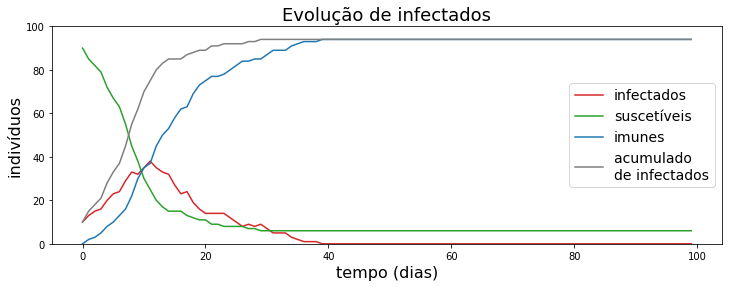

In [15]:
plt.figure(figsize=(12,4))
plt.plot(num_infectados, '-', color='tab:red', label='infectados')
plt.plot(num_suscetiveis, '-', color='tab:green', label='suscetíveis')
plt.plot(num_recuperados, '-', color='tab:blue', label='imunes')
plt.plot(num_individuos - num_suscetiveis, '-', color='tab:gray', label='acumulado \nde infectados')
plt.xlabel('tempo (dias)', fontsize=16)
plt.ylabel('indivíduos', fontsize=16)
plt.title('Evolução de infectados', fontsize=18)
plt.ylim(0, num_individuos)
plt.legend(fontsize=14)
plt.show()

#### Outras simulações

Nas células abaixo, juntamos o código necessário para fazer simulações, de uma vez só, com novos parâmetros, e exibir o gráfico.

In [16]:
# parâmetros
num_individuos = 100
num_infectados0 = 10
fator_de_transmissao = 0.8
fator_de_recuperacao = 0.15

# inicialização
populacao0 = 2*np.ones(num_individuos)
infectados0 = np.random.choice(num_individuos, num_infectados0)
populacao0[infectados0] = np.ones(num_infectados0)

# evolução
tmax = 100
populacao = np.copy(populacao0)
num_infectados = np.array([num_infectados0])
num_suscetiveis = np.array([num_individuos - num_infectados0])
num_recuperados = np.array([0])
for t in range(1,tmax):
    populacao = evolui(populacao, fator_de_transmissao, fator_de_recuperacao)
    num_infectados = np.hstack([num_infectados, np.count_nonzero(populacao==1)])
    num_suscetiveis = np.hstack([num_suscetiveis, np.count_nonzero(populacao==2)])
    num_recuperados = np.hstack([num_recuperados, np.count_nonzero(populacao==3)])

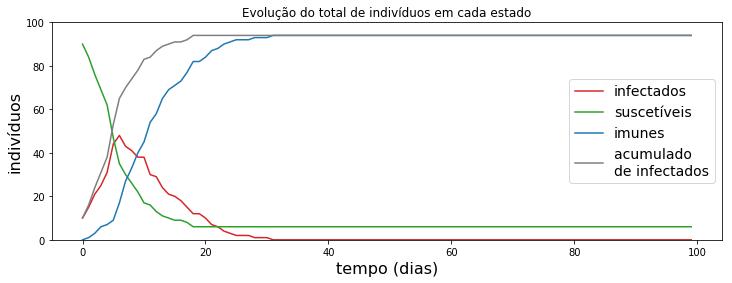

In [17]:
plt.figure(figsize=(12,4))
plt.plot(num_infectados, '-', color='tab:red', label='infectados')
plt.plot(num_suscetiveis, '-', color='tab:green', label='suscetíveis')
plt.plot(num_recuperados, '-', color='tab:blue', label='imunes')
plt.plot(num_individuos - num_suscetiveis, '-', color='tab:gray', label='acumulado \nde infectados')
plt.xlabel('tempo (dias)', fontsize=16)
plt.ylabel('indivíduos', fontsize=16)
plt.title('Evolução do total de indivíduos em cada estado', fontsize=12)
plt.ylim(0, num_individuos)
plt.legend(fontsize=14)

plt.show()

#### Simulação de Monte-Carlo - Superposição de evoluções

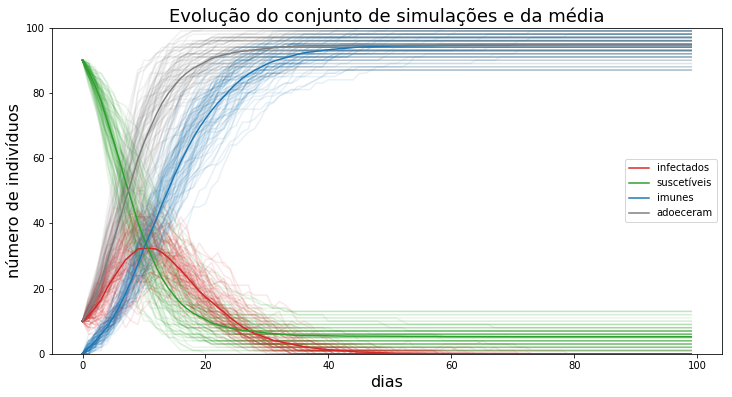

CPU times: user 2.95 s, sys: 41.1 ms, total: 2.99 s
Wall time: 3.04 s


In [18]:
%%time 
# parâmetros
num_individuos = 100
num_infectados0 = 10
fator_de_transmissao = 0.8
fator_de_recuperacao = 0.15 # entre seis e sete dias de recuperação, em média

# dias para cada evolução
tmax = 100

# número de simulações
num_simulacoes = 80

# inicializa figura e define eixo vertical
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# inicializa variáveis para o cálculo da média
num_infectados_mean = np.zeros(num_individuos)
num_suscetiveis_mean = np.zeros(num_individuos)
num_recuperados_mean = np.zeros(num_individuos)
num_adoeceram_mean = np.zeros(num_individuos)

# simulações
for k in range(num_simulacoes):
    # inicializa população de cada simulação
    populacao = np.copy(populacao0)
    num_infectados = np.array([num_infectados0])
    num_suscetiveis = np.array([num_individuos - num_infectados0])
    num_recuperados = np.array([0])
    num_adoeceram = np.array([0])
    
    # evolui o dia e armazena as novas contagens
    for t in range(1,tmax):
        populacao = evolui(populacao, fator_de_transmissao, fator_de_recuperacao)
        num_infectados = np.hstack([num_infectados, np.count_nonzero(populacao==1)])
        num_suscetiveis = np.hstack([num_suscetiveis, np.count_nonzero(populacao==2)])
        num_recuperados = np.hstack([num_recuperados, np.count_nonzero(populacao==3)])
    
    # adiciona as contagens dessa simulação para o cálculo final da média
    num_infectados_mean += num_infectados
    num_suscetiveis_mean += num_suscetiveis
    num_recuperados_mean += num_recuperados
    num_adoeceram_mean += num_individuos - num_suscetiveis

    # exibe os gráficos dos dados dessa simulação
    plt.plot(num_infectados, color='tab:red', alpha=0.1)
    plt.plot(num_suscetiveis, '-', color='tab:green', alpha=0.1)
    plt.plot(num_recuperados, '-', color='tab:blue', alpha=0.1)
    plt.plot(num_individuos - num_suscetiveis, '-', color='tab:gray', alpha=0.1)

# divide pelo número de evoluções para obter a média, melhor fazer isso ao final
# para reduzir erros de arredondamento
num_infectados_mean /= num_simulacoes
num_suscetiveis_mean /= num_simulacoes
num_recuperados_mean /= num_simulacoes
num_adoeceram_mean /= num_simulacoes

# exibe os gráficos das médias
plt.plot(num_infectados_mean, '-', color='tab:red', label='infectados')
plt.plot(num_suscetiveis_mean, '-', color='tab:green', label='suscetíveis')
plt.plot(num_recuperados_mean, '-', color='tab:blue', label='imunes')
plt.plot(num_adoeceram_mean, '-', color='tab:gray', label='adoeceram')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução do conjunto de simulações e da média', fontsize=18)
plt.legend()
plt.show() 

## Exercícios

1. Ajuste os parâmetros $\beta$, $\gamma$ aos dados da epidemia de *Influenza* em um escola de meninos no norte da Inglaterra, com um total de 763 residentes, em um período de duas semanas, em que, a cada dia, o número de infectados é dado pela lista

$$ \text{Infectados} = [1, 3, 7, 25, 72, 222, 282, 256, 233, 189, 123, 70, 25, 11, 4]
$$

### Opções para acelerar o código

#### Códigos para contar número de estados da população

A célula a seguir mede os tempos de execução de vários métodos para se calcular o número de estados (`0`, `1`, `2` e `3`) da população, para definir o método a ser utilizado na cálculo da evolução.

Claramente, `numpy.count_nonzero` é mais rápido.

In [ ]:
choices = np.random.randint(0, 4, 10000)

%timeit [ np.sum(choices == k) for k in range(min(choices), max(choices)+1) ]

%timeit np.sum(choices == 1)

%timeit np.unique(choices==1, return_counts=True)

%timeit np.unique(choices==1)

%timeit np.bincount(choices, minlength=np.size(choices))

%timeit np.bincount(choices == 1)

%timeit np.count_nonzero(choices == 1)

Usando `numpy.count_nonzero`, podemos contar a ocorrência de duas formas diferentes. Naturalmente a segunda opção abaixo é a mais rápida.

In [ ]:
#help(np.count_nonzero)
choices = np.random.randint(0, 4, 1000)
%timeit [np.count_nonzero(choices==k) for k in range(4)]
%timeit np.count_nonzero([choices==0, choices==1, choices==2, choices==3], axis=1)
%timeit np.count_nonzero([choices==k for k in range(4)], axis=1)

#### Códigos para vetorizar uma função 

In [ ]:
def testfun(x):
    if 0 <= x <=1:
         return x**2
    elif x>1:
          return 1-2*(x-1)*(x-2)
    elif x<0:
        return 0.0

vtestfun = np.vectorize(testfun)

x = np.arange(-2,2,0.01)
y = vtestfun(x)
plt.figure(figsize=(10,6))
plt.plot(x, y, '-')
plt.show()

Um jeito mais econômico de implementar a vetorização é através de um "decorador" (veja [Real Python: Primer on Python Decorators](https://realpython.com/primer-on-python-decorators/)).

O decorador `@np.vectorize` antes da definição `def testfun(x):` da função tem 

In [ ]:
@np.vectorize
def testfun(x):
    if 0 <= x <=1:
         return x**2
    elif x>1:
          return 1-2*(x-1)*(x-2)
    elif x<0:
        return 0.0

x = np.arange(-2,2,0.01)
y = testfun(x)
plt.figure(figsize=(10,6))
plt.plot(x, y, '-')
plt.show()

In [ ]:
def testfun2(a, b):
    "Return a-b if a>b, otherwise return a+b"
    if a > b:
        return a - b
    else:
        return a + b
    
vfunc = np.vectorize(testfun2)
vfunc([1, 2, 3, 4], [4,3,2,1])

#### Teste de velocidade

Naturalmente, a função vetorizada é mais rápida, mas de fato ela é extremamente mais rápida. A não vetorizada é em torno de sessenta vezes mais lenta:

In [ ]:
x = 4*np.random.rand(1000) - 1
%timeit [testfun(x[j]) for j in range(1000)]
%timeit testfun(x)

## Fontes úteis

- [Using Real Data in an SIR Model by D. Sulsky](https://math.unm.edu/~sulsky/mathcamp/ApplyData.pdf)

- [A New SIR-based Model for Influenza Epidemic](https://waset.org/publications/1303/a-new-sir-based-model-for-influenza-epidemic)

- [Towards Data Science: Infection Modeling — Part 1 - Estimating the Impact of a Pathogen via Monte Carlo Simulation](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)

- [Towards Data Science: Infection Modeling — Part 2 - Optimizing a Vaccination Strategy with Genetic Algorithms](https://towardsdatascience.com/infection-modeling-part-2-5d3f394355f)

- [Towards Data Science: Infection Modeling — Part 3 - Optimizing a vaccination strategy with network science](https://towardsdatascience.com/infection-modeling-part-3-93ef315edae1)

## Dengue no Rio de Janeiro

Dados dos casos de dengue registrados no Rio de Janeiro, distribuídos por semana e bairro, podem ser acessados pela página [Rio Prefeitura - Dengue](http://www.rio.rj.gov.br/web/sms/dengue) (ou diretamente na página [Dengue: dados epidemiológicos](http://www.rio.rj.gov.br/web/sms/exibeconteudo?id=2815389)).

---

### Apresentação em slides

Para visualizar na forma de slides, abrir um "terminal" *bash* e usar a linha de comando
```bash
jupyter nbconvert 11.00-Aula11.ipynb --to slides --post serve
```

Se quiser adicionar a possibilidade de rolar a página, caso algum *slide* seja muito longo, incluir a opção
```bash
--SlidesExporter.reveal_scroll=True
```

Para usar um tema diferente do padrão, temos a configuração via `SlidesExporter.reveal_theme`. Os temas disponíveis são `beige`, `black`, `blood`, `league`, `moon`, `night`, `serif`, `simple`, `sky`, `solarized`, `white`. O padrão é `white`. Um tema interessante é
```bash
--SlidesExporter.reveal_theme=solarized
```

Para usar um efeito de transição diferente do padrão, temos a configuração via `SlidesExporter.reveal_transition`. As opções são `none`, `fade`, `slide`, `convex`, `concave` e `zoom`. O padrão é `slide`. Uma transição interessante é 
```bash
--SlidesExporter.reveal_transition=convex
```

Mais informações sobre o `nbconvert` em [Configuration options (for nbconvert)](https://nbconvert.readthedocs.io/en/latest/config_options.html) e [Present Your Data Science Projects with Jupyter Notebook Slides!](https://medium.com/learning-machine-learning/present-your-data-science-projects-with-jupyter-slides-75f20735eb0f)

<!--NAVIGATOR-->

---
[<- Aula 9: Pêndulo via deteção de movimento](09.00-Aula9.ipynb) | [Página Inicial](00-Sumario.ipynb) 

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/11.00-Aula11.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/11.00-Aula11.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>

<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/11.00-Aula11.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;